In [1]:
# Are we using a GPU?
!nvidia-smi

Mon Nov  6 12:19:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-06 12:19:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-06 12:19:31 (49.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2023-11-06 12:19:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.207, 173.194.197.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   154MB/s    in 12s     

2023-11-06 12:19:47 (133 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
test_dir = "101_food_classes_10_percent/train/"
train_dir = "101_food_classes_10_percent/test/"

In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_cla

In [7]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 25250 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [8]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [9]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)


In [10]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [11]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation-- can add to helper fn if it gives good result
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [12]:
train_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [13]:
len(train_data.class_names), len(test_data.class_names),

(101, 101)

In [14]:
# Setup base model and freeze its layers (this will extract features)
#base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# effivientNetB0 gives 1000 by default, we want 100 images output(feature extraction)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes, only layer that is trained, above all are frozen
model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [15]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [16]:
# Compile and Fit
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_1 = model.fit(                     train_data,
                                           epochs=15, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[checkpoint_callback,early_stopping,reduce_lr]) # save best model weights to file


Epoch 1/15
790/790 [==============================] - 325s 392ms/step - loss: 2.5351 - accuracy: 0.4192 - val_loss: 1.8774 - val_accuracy: 0.5292 - lr: 0.0010
Epoch 2/15
790/790 [==============================] - 185s 233ms/step - loss: 1.7105 - accuracy: 0.5648 - val_loss: 1.6792 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 3/15
790/790 [==============================] - 164s 207ms/step - loss: 1.5077 - accuracy: 0.6103 - val_loss: 1.5998 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 4/15
790/790 [==============================] - 128s 162ms/step - loss: 1.4011 - accuracy: 0.6333 - val_loss: 1.5628 - val_accuracy: 0.5964 - lr: 0.0010
Epoch 5/15
790/790 [==============================] - 113s 142ms/step - loss: 1.3149 - accuracy: 0.6522 - val_loss: 1.5307 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 6/15
790/790 [==============================] - 105s 132ms/step - loss: 1.2539 - accuracy: 0.6680 - val_loss: 1.5168 - val_accuracy: 0.6121 - lr: 0.0010
Epoch 7/15
790/790 [==========================

In [17]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

237/237 [==============================] - 17s 69ms/step - loss: 1.4469 - accuracy: 0.6343


[1.4469246864318848, 0.6343234181404114]

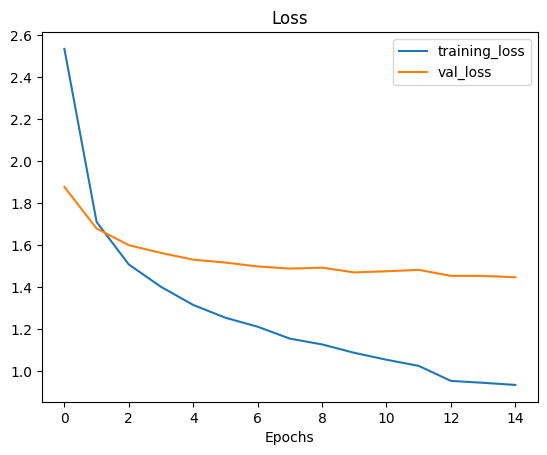

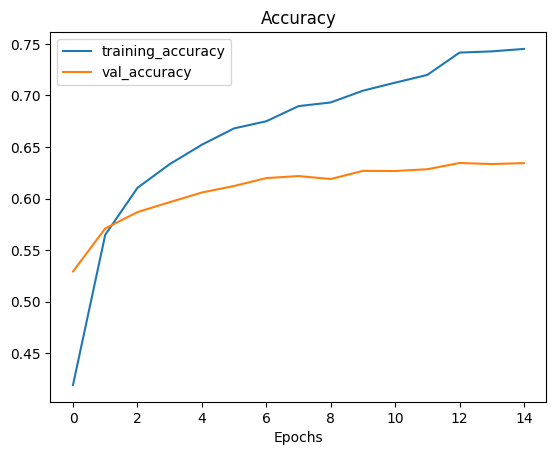

In [18]:
plot_loss_curves(history_1)

In [19]:
base_model.trainable = True # all the layers in  base model are trainable

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False # all the layers except the last 20 are now frozen

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [20]:
# Fine tune for another 5 epochs

fine_tune_epochs = 30 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_2 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=int(len(test_data)), # validate on 15% of the test data
                      initial_epoch=history_1.epoch[-1],
                      callbacks=[checkpoint_callback,early_stopping,reduce_lr]
                      ) # start from previous last epoch



Epoch 15/30
790/790 [==============================] - 93s 103ms/step - loss: 0.8935 - accuracy: 0.7528 - val_loss: 1.4858 - val_accuracy: 0.6370 - lr: 1.0000e-04
Epoch 16/30
790/790 [==============================] - 77s 96ms/step - loss: 0.8415 - accuracy: 0.7643 - val_loss: 1.4712 - val_accuracy: 0.6418 - lr: 1.0000e-04
Epoch 17/30
790/790 [==============================] - 77s 98ms/step - loss: 0.7990 - accuracy: 0.7736 - val_loss: 1.4751 - val_accuracy: 0.6438 - lr: 1.0000e-04
Epoch 18/30
790/790 [==============================] - 84s 106ms/step - loss: 0.7662 - accuracy: 0.7838 - val_loss: 1.4692 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 19/30
790/790 [==============================] - 77s 97ms/step - loss: 0.7371 - accuracy: 0.7901 - val_loss: 1.4831 - val_accuracy: 0.6484 - lr: 1.0000e-04
Epoch 20/30
790/790 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.8000
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
790/790 [====

In [21]:
results_feature_extraction_model_fine_tuned = model.evaluate(test_data)
results_feature_extraction_model_fine_tuned

237/237 [==============================] - 17s 72ms/step - loss: 1.4841 - accuracy: 0.6515


[1.4841400384902954, 0.6514851450920105]

15
22
[0.41920793056488037, 0.5647920966148376, 0.6102970242500305, 0.633267343044281, 0.6521584391593933, 0.6679999828338623, 0.6748911142349243, 0.6895841360092163, 0.6931484937667847, 0.7045544385910034, 0.7123168110847473, 0.7198415994644165, 0.741504967212677, 0.7426930665969849, 0.7450693249702454, 0.7528316974639893, 0.7643168568611145, 0.7736237645149231, 0.7837623953819275, 0.790099024772644, 0.8000395894050598, 0.8171485066413879]


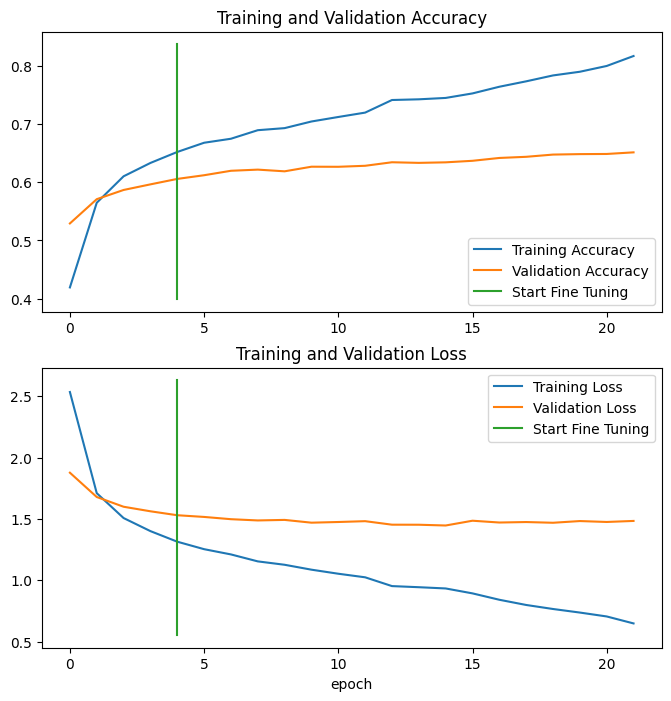

In [22]:

#plot_loss_curve fn works great for models which have been only fit once but not for before and after fine tuning
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=15):
    """
    Compares two model history objects. model_2 and model_3 ie before and after fine tuning
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

compare_historys(original_history=history_1,
                 new_history=history_2,
                 initial_epochs=5)


In [23]:
model.save("efficientnet_v2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
model = tf.keras.models.load_model('efficientnet_v2.h5')
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)
pred_probs.shape



237/237 [==============================] - 21s 77ms/step


(7575, 101)

In [28]:
test_data.class_names[52]
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [29]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [30]:
#Actual y labels
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
print(len(y_labels))
y_labels[:10], pred_classes[:10]

7575


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([ 8, 16,  0, 22, 39,  8,  0,  8,  8, 42]))

In [31]:

# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6514851485148515

In [32]:
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### ADDED: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [33]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))  # 0-55 are classes ie food labels

              precision    recall  f1-score   support

           0       0.43      0.45      0.44        75
           1       0.73      0.69      0.71        75
           2       0.74      0.68      0.71        75
           3       0.68      0.64      0.66        75
           4       0.80      0.43      0.56        75
           5       0.57      0.52      0.54        75
           6       0.80      0.79      0.79        75
           7       0.86      0.83      0.84        75
           8       0.31      0.57      0.40        75
           9       0.54      0.73      0.62        75
          10       0.59      0.55      0.57        75
          11       0.79      0.71      0.75        75
          12       0.68      0.71      0.69        75
          13       0.58      0.63      0.60        75
          14       0.58      0.51      0.54        75
          15       0.51      0.43      0.46        75
          16       0.57      0.72      0.64        75
          17       0.46    

In [35]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.43037974683544306,
  'recall': 0.4533333333333333,
  'f1-score': 0.44155844155844154,
  'support': 75},
 '1': {'precision': 0.7323943661971831,
  'recall': 0.6933333333333334,
  'f1-score': 0.7123287671232877,
  'support': 75},
 '2': {'precision': 0.7391304347826086,
  'recall': 0.68,
  'f1-score': 0.7083333333333334,
  'support': 75},
 '3': {'precision': 0.676056338028169,
  'recall': 0.64,
  'f1-score': 0.6575342465753424,
  'support': 75},
 '4': {'precision': 0.8,
  'recall': 0.4266666666666667,
  'f1-score': 0.5565217391304348,
  'support': 75},
 '5': {'precision': 0.5652173913043478,
  'recall': 0.52,
  'f1-score': 0.5416666666666667,
  'support': 75},
 '6': {'precision': 0.7972972972972973,
  'recall': 0.7866666666666666,
  'f1-score': 0.7919463087248321,
  'support': 75},
 '7': {'precision': 0.8611111111111112,
  'recall': 0.8266666666666667,
  'f1-score': 0.8435374149659863,
  'support': 75},
 '8': {'precision': 0.30935251798561153,
  'recall': 0.573333333

In [36]:
# Create empty dictionary
#Focus on F1 score for our classifiation problem
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key ie after 99th value
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.44155844155844154,
 'baby_back_ribs': 0.7123287671232877,
 'baklava': 0.7083333333333334,
 'beef_carpaccio': 0.6575342465753424,
 'beef_tartare': 0.5565217391304348,
 'beet_salad': 0.5416666666666667,
 'beignets': 0.7919463087248321,
 'bibimbap': 0.8435374149659863,
 'bread_pudding': 0.4018691588785047,
 'breakfast_burrito': 0.625,
 'bruschetta': 0.5655172413793104,
 'caesar_salad': 0.7464788732394366,
 'cannoli': 0.6928104575163399,
 'caprese_salad': 0.6025641025641025,
 'carrot_cake': 0.5428571428571428,
 'ceviche': 0.463768115942029,
 'cheese_plate': 0.6352941176470588,
 'cheesecake': 0.496969696969697,
 'chicken_curry': 0.5850340136054423,
 'chicken_quesadilla': 0.5826771653543308,
 'chicken_wings': 0.751592356687898,
 'chocolate_cake': 0.6198830409356726,
 'chocolate_mousse': 0.391304347826087,
 'churros': 0.676056338028169,
 'clam_chowder': 0.8333333333333334,
 'club_sandwich': 0.7019867549668874,
 'crab_cakes': 0.5256410256410257,
 'creme_brulee': 0.7832167832167

In [37]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33            edamame  0.967742
75                pho  0.921053
64          miso_soup  0.893082
54  hot_and_sour_soup  0.882759
51          guacamole  0.868421
..                ...       ...
39          foie_gras  0.415584
77          pork_chop  0.402235
8       bread_pudding  0.401869
22   chocolate_mousse  0.391304
99       tuna_tartare  0.387879

[101 rows x 2 columns]

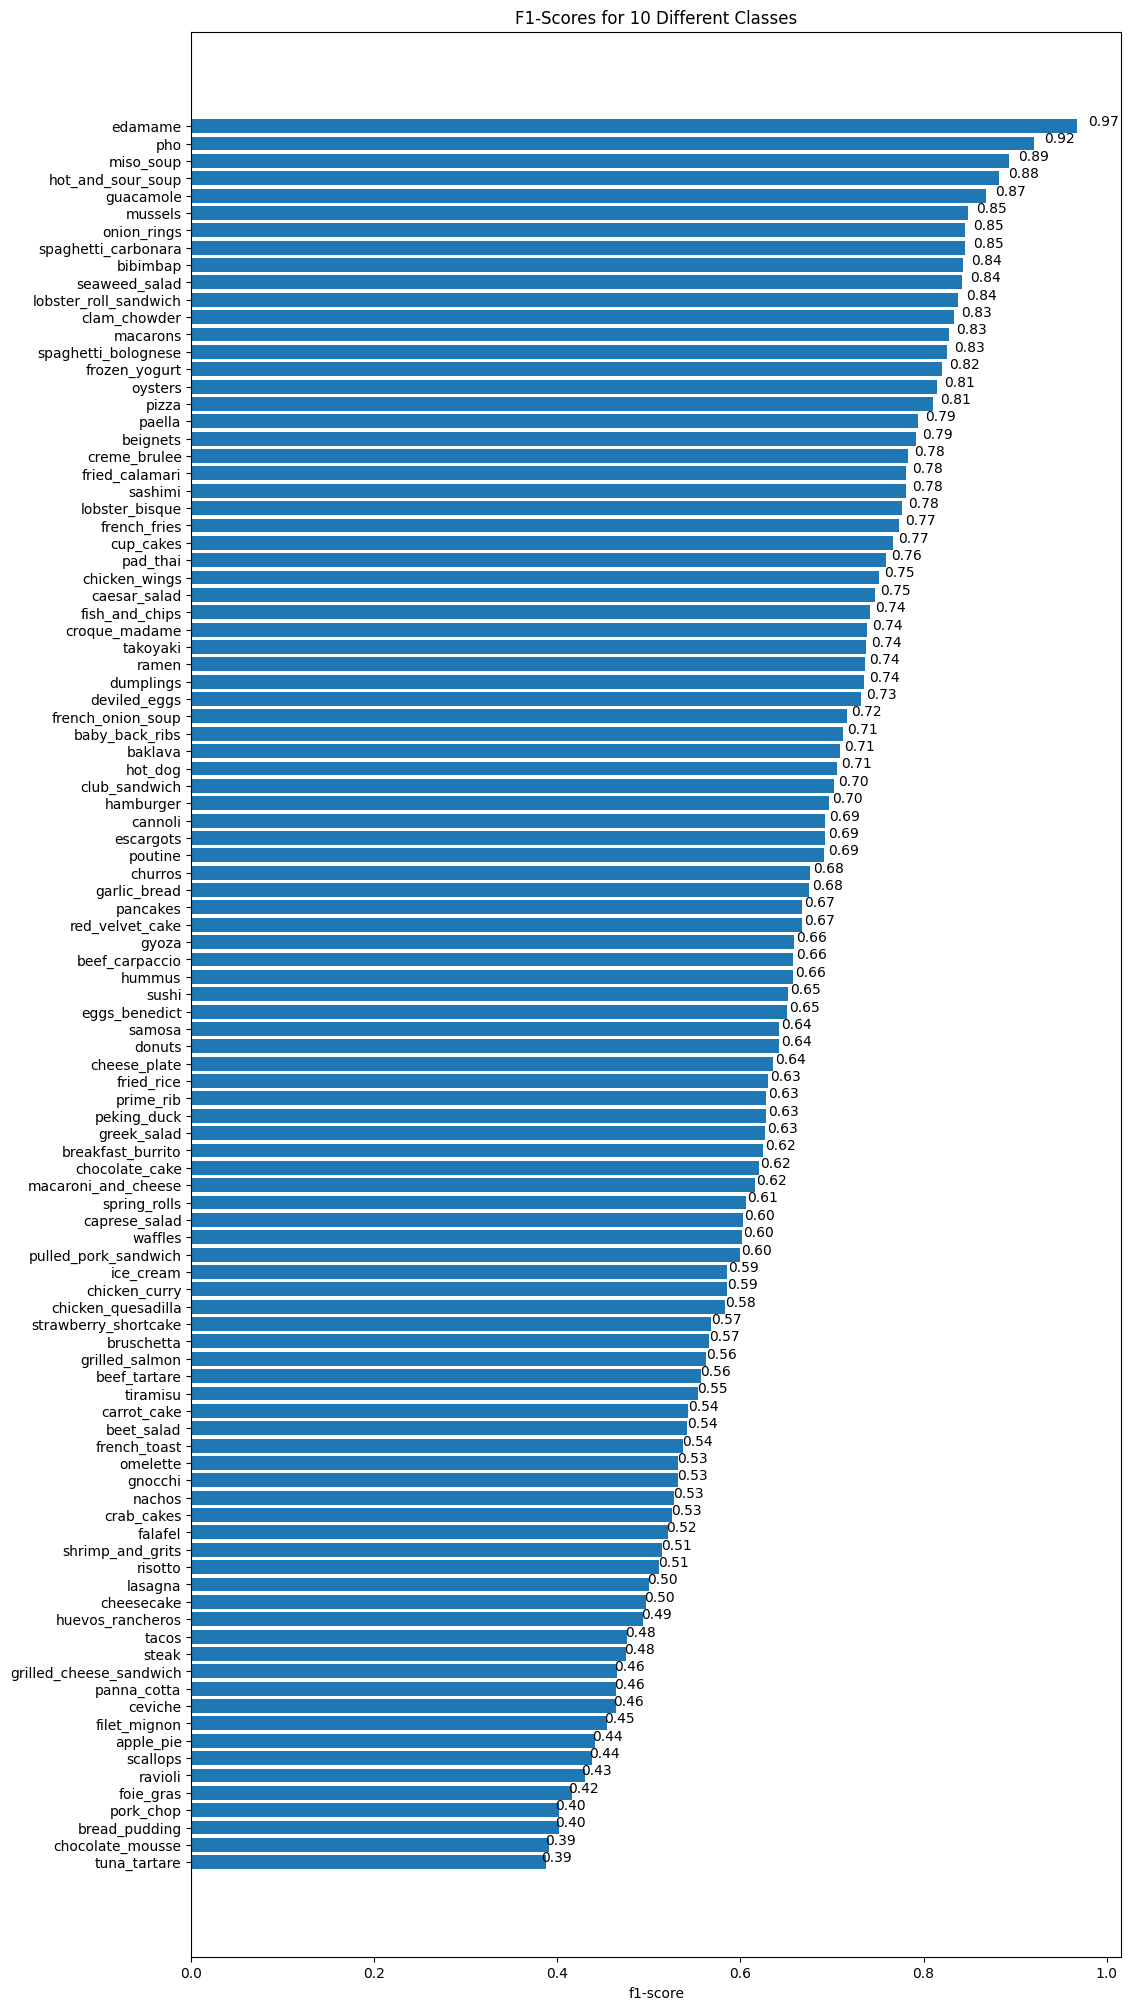

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order ie arrange from highest to lowest

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value). ie label above every bar
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

1/1 [==============================] - 0s 39ms/step


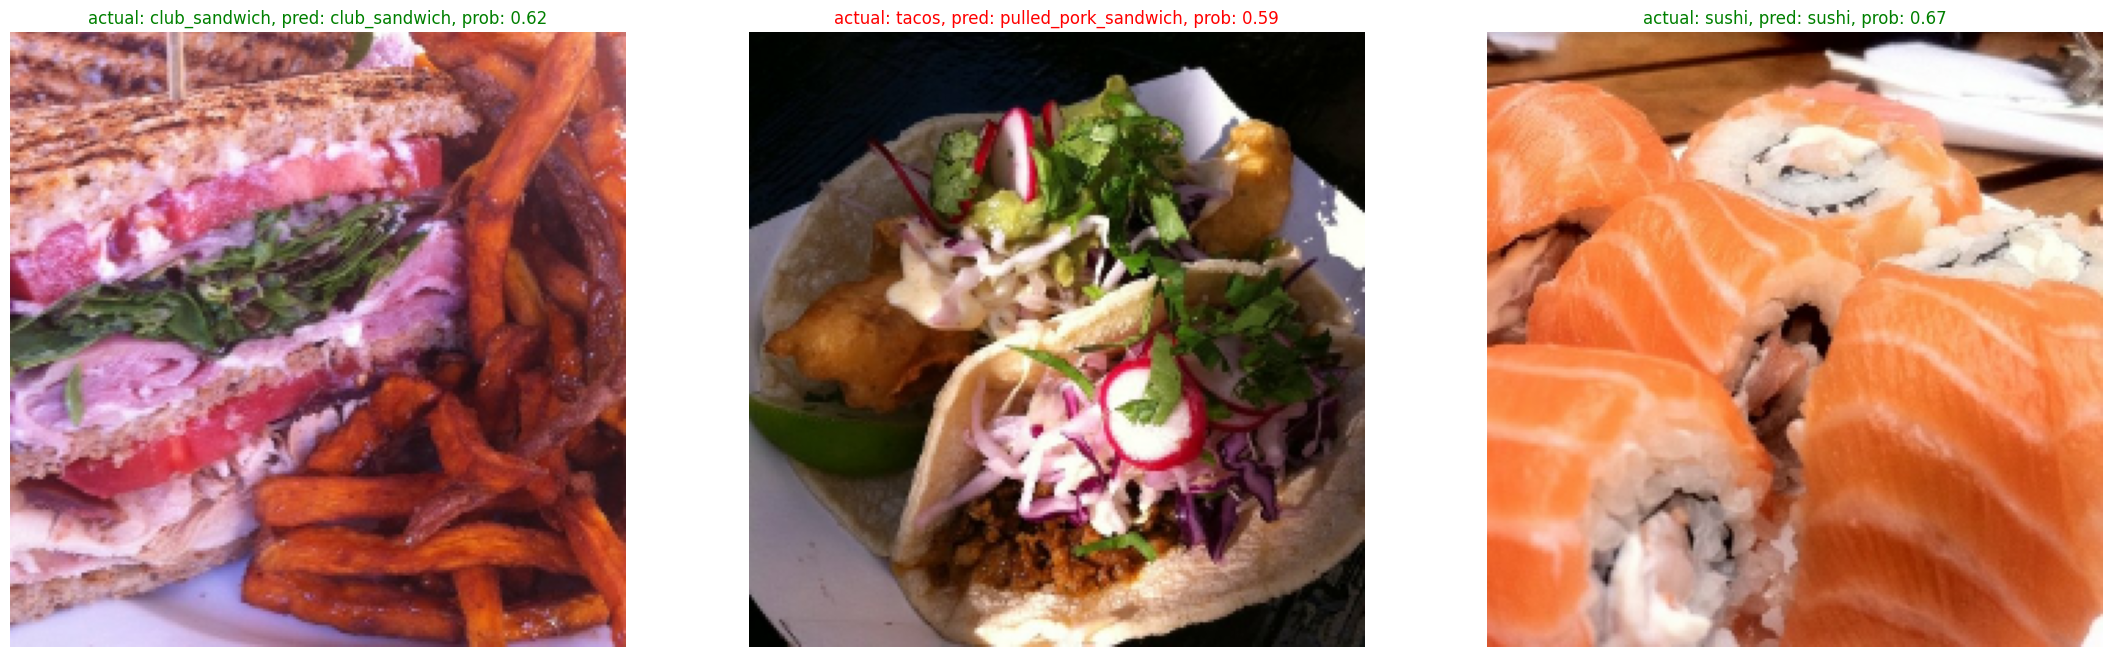

In [39]:
def load_and_prep_image(filename, img_shape=224, scale=True): # scale is normalization
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3) # remove channels if full code doesn't work. 3 because if png file is uploaded, it has 4 channel. we are setting it to default
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # for efficientnetB0


# Make preds on a series of random images
import os
import random

plt.figure(figsize=(27, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3] so expand_dims is necessary
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [41]:
#Finding the most wrong predictions
""" model predicting on some images with a very high prediction probability,
meaning it's very confident with its prediction but still getting the label wrong.
These most wrong predictions can help to give further insight
into your model's performance ie close to 1 predicting but wrong prediction"""

# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/train/*/*.jpg", #2 * means all classes and all jpegs
                                     shuffle=False):
  filepaths.append(filepath.numpy()) # without .numpy it is in tensorflow format but we want in .jpg format
filepaths[:10]


# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_confidence": pred_probs.max(axis=1), # get the maximum prediction probability value (pred confidence )
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/train/apple_pie/...       0       8   
1  b'101_food_classes_10_percent/train/apple_pie/...       0      16   
2  b'101_food_classes_10_percent/train/apple_pie/...       0       0   
3  b'101_food_classes_10_percent/train/apple_pie/...       0      22   
4  b'101_food_classes_10_percent/train/apple_pie/...       0      39   

   pred_confidence y_true_classname  y_pred_classname  pred_correct  
0         0.275235        apple_pie     bread_pudding         False  
1         0.441914        apple_pie      cheese_plate         False  
2         0.914344        apple_pie         apple_pie          True  
3         0.734180        apple_pie  chocolate_mousse         False  
4         0.309444        apple_pie         foie_gras         False

In [43]:

# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_confidence", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
5439  b'101_food_classes_10_percent/train/pancakes/3...      72     100   
6987  b'101_food_classes_10_percent/train/steak/1849...      93      79   
6287  b'101_food_classes_10_percent/train/red_velvet...      83      29   
2436  b'101_food_classes_10_percent/train/dumplings/...      32      52   
7488  b'101_food_classes_10_percent/train/tuna_tarta...      99       3   
4937  b'101_food_classes_10_percent/train/mussels/50...      65      69   
7024  b'101_food_classes_10_percent/train/steak/3322...      93      79   
3102  b'101_food_classes_10_percent/train/french_oni...      41      81   
7173  b'101_food_classes_10_percent/train/sushi/3441...      95      86   
6641  b'101_food_classes_10_percent/train/seaweed_sa...      88      64   
2323  b'101_food_classes_10_percent/train/deviled_eg...      30      29   
3466  b'101_food_classes_10_percent/train/garlic_bre...      46      76   
836   b'101_food_classes_10_percent/train/caesar_sal...      11      48   
7315  b'101_food_classes_10_percent/train/takoyaki/2...      97      81   
6281  b'101_food_classes_10_percent/train/red_velvet...      83      21   
2007  b'101_food_classes_10_percent/train/crab_cakes...      26      38   
5477  b'101_food_classes_10_percent/train/panna_cott...      73      17   
2171  b'101_food_classes_10_percent/train/croque_mad...      28      34   
2473  b'101_food_classes_10_percent/train/dumplings/...      32      85   
471   b'101_food_classes_10_percent/train/beignets/1...       6      12   

      pred_confidence   y_true_classname y_pred_classname  pred_correct  
5439         1.000000           pancakes          waffles         False  
6987         0.999995              steak        prime_rib         False  
6287         0.999974    red_velvet_cake        cup_cakes         False  
2436         0.999886          dumplings            gyoza         False  
7488         0.999822       tuna_tartare   beef_carpaccio         False  
4937         0.999740            mussels          oysters         False  
7024         0.999725              steak        prime_rib         False  
3102         0.999308  french_onion_soup            ramen         False  
7173         0.999232              sushi          sashimi         False  
6641         0.999091      seaweed_salad        miso_soup         False  
2323         0.998774       deviled_eggs        cup_cakes         False  
3466         0.998698       garlic_bread            pizza         False  
836          0.998271       caesar_salad      greek_salad         False  
7315         0.998104           takoyaki            ramen         False  
6281         0.997864    red_velvet_cake   chocolate_cake         False  
2007         0.997770         crab_cakes   fish_and_chips         False  
5477         0.996759        panna_cotta       cheesecake         False  
2171         0.996502      croque_madame    eggs_benedict         False  
2473         0.995973          dumplings           samosa         False  
471          0.995771           beignets          cannoli         False

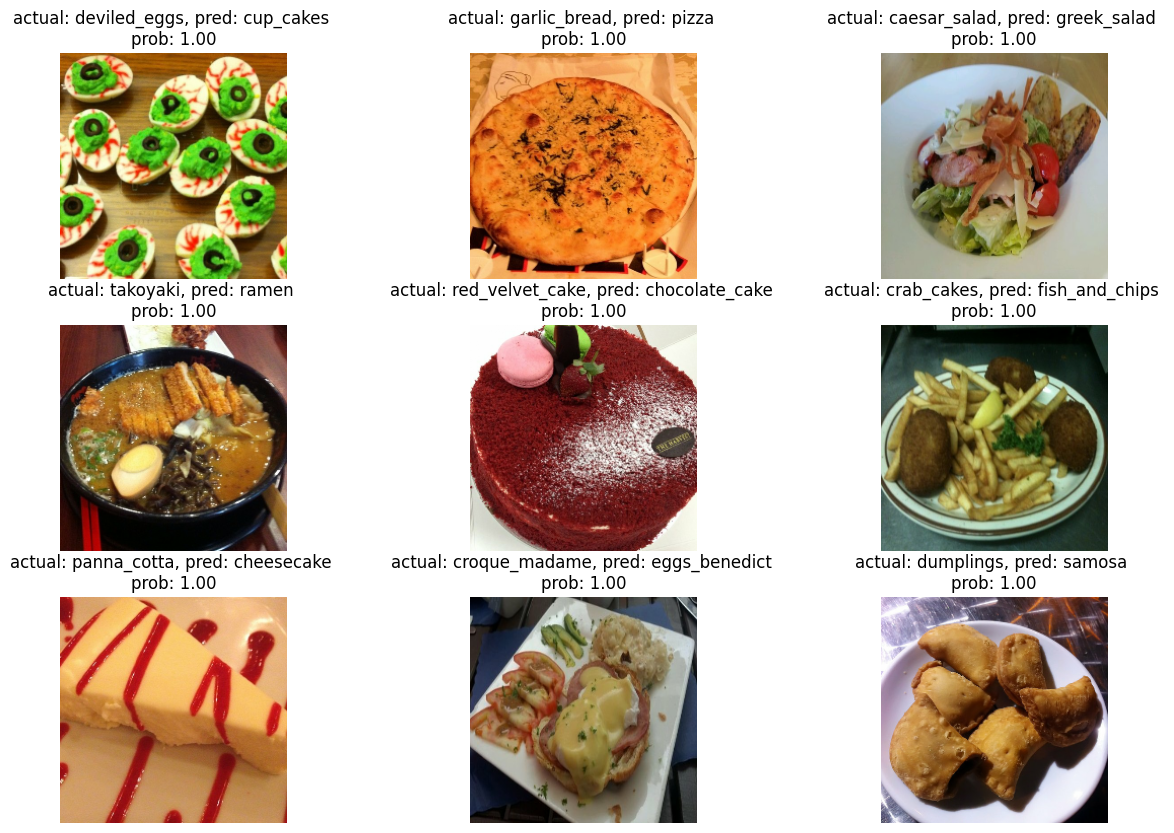

In [44]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):  # tuple in row
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True) # row[1] is b'101_food_classes_10_percent/test/scallops/17..., change scale to False
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row, _, is skipping those many columns in a tuple
  plt.imshow(img) # img/255.
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)